# Курсовой проект курса "Рекомендательные системы"
## Задача:

Требуется, на основании имеющихся исторических данных по продажам за последние 92 недели и признаковых описаниях покупателей и товаров, реализовать алгоритм прогнозирующий будущие покупки и формирующий список рекомендуемых товаров на будущие 3 недели.

## Обзор данных:

* retail_train - данные о покупках 2.5k клиентов 80k товаров
* product - признаковое описание товаров
* hh_demographic - признаковое описание пользователей
* retail_test1 - тестовые данные для предсказаний (3 недели)

## Метрика качества:

**precision@5**

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
warnings.filterwarnings('ignore')

In [2]:
from src.recommenders import MainRecommender
from src.utils import prefilter_items, reduce_mem_usage, show_feature_importances
from src.metrics import precision, recall
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from implicit import als
import ast
from scipy.stats import mode
from scipy.sparse import csr_matrix

# Read data

In [3]:
data = reduce_mem_usage(pd.read_csv('data/retail_train.csv'))
item_features = reduce_mem_usage(pd.read_csv('data/product.csv'))
user_features = reduce_mem_usage(pd.read_csv('data/hh_demographic.csv'))
test_data = reduce_mem_usage(pd.read_csv('data/retail_test1.csv'))
data_train = data.copy()

Memory usage of dataframe is 219.43 MB
Memory usage after optimization is: 98.29 MB
Decreased by 55.2%
Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 1.53 MB
Decreased by 68.9%
Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.01 MB
Decreased by 82.8%
Memory usage of dataframe is 8.12 MB
Memory usage after optimization is: 3.64 MB
Decreased by 55.2%


In [4]:
display(data.head(2), item_features.head(2), user_features.head(2))

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [5]:
# уникальные юзеры в test
test_data[~test_data['user_id'].isin(data['user_id'])]['user_id'].unique()

array([2325], dtype=int16)

In [6]:
# холодный старт не рассматривается поэтому юзера удаляем из test выборки.
# альтернатива - предложить товары из топа
test_data.drop(test_data[test_data['user_id'] == 2325].index,
               inplace=True)

## Preprocessing, data split

In [7]:
# приведение датафреймов к общему виду
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL}, inplace=True)

In [8]:
N_TOP_ITEMS = 7000  # выбор топ товаров
VAL_TRAIN_WEEKS = 3

In [9]:
data_train_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_TRAIN_WEEKS]

In [10]:
# фильтрация товарво по условию
# в данном случае остаются топ 7000 товаров

n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train,
                             group_col='item_id',
                             popular_col='quantity',
                             top_popular_filter_choose=N_TOP_ITEMS,
                             )

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Отфильтровано 703754 записей
Decreased # items from 89051 to 7001


## Test baseline

In [11]:
# get metrics
def calc_precision(df_data, top_k, start=2, stop=None):
    score_dict = {}
    for col_name in df_data.columns[start:stop]:
        score = df_data.apply(lambda row: precision(
            row[col_name], row[1], top_k=top_k), axis=1).mean()
        score_dict[col_name] = score
    return score_dict


def calc_recall(df_data, top_k, start=2, stop=None):
    score_dict = {}
    for col_name in df_data.columns[start:stop]:
        score = df_data.apply(lambda row: recall(
            row[col_name], row[ACTUAL_COL], top_k=top_k), axis=1).mean()
        score_dict[col_name] = score
    return score_dict

In [12]:
recommender = MainRecommender(verbose=False)
recommender.fit(data_train)

In [13]:
df_results = test_data.groupby(USER_COL)[ITEM_COL].unique().reset_index()
df_results.columns = [USER_COL, ACTUAL_COL]

In [14]:
df_results['own_rec_baseline'] = df_results[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=5))
print('*'*100)
print( f'Precicion@5 baseline own recommender: {calc_precision(df_results, top_k=5)["own_rec_baseline"]}')

****************************************************************************************************
Precicion@5 baseline own recommender: 0.19564755838640968


## Test of matching

Подобор параметров ALS для подбора кандидатов проведен в **отдельном ноутбуке** "TEST PARAMS".
При этом вопрос выбора метрики остался открытым. Тест на отимальный precision@k показал результаты хуже, на модели вроторого уровня. Recall бессмыслено было опитимизировать так как с ростом n_factors recall тоже растет. (а безлимитно увеличивать n_factors нельзя). Опитимизация метрик ранжирования тоже не дала ожидаемых результатов на модели второго уровня.
Как вариант подбор параметров должен проходить в **комплексе** на модели 1 и 2 уровня

******

# Init/train recommender - 
## **1-level model (matching)**

In [15]:
recommender = MainRecommender(verbose=False,
                              n_factors=140,
                              regularization=0.07
                              )
recommender.fit(data_train)

In [16]:
# число кандидатов
N_PREDICT = 500

In [17]:
df_match_candidates = test_data.groupby(USER_COL)[ITEM_COL].unique().reset_index()
df_match_candidates.columns=[USER_COL, ACTUAL_COL]

In [18]:
# подбор кандидатов
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(
    lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

In [19]:
precision_1_lvl = df_match_candidates.apply(lambda row: precision(
    row["candidates"], row[ACTUAL_COL], top_k=5), axis=1).mean()
recall_1_lvl = df_match_candidates.apply(lambda row: recall(
    row["candidates"], row[ACTUAL_COL], top_k=N_PREDICT), axis=1).mean()

print('*'*100)
print('МЕТРИКИ МОДЕЛИ ПЕРВОГО УРОВНЯ')
print(f'Precicion@5 1-level own_rec model: {round(precision_1_lvl, 4)}')
print(f'Recall@{N_PREDICT} 1-level own_rec model: {round(recall_1_lvl, 4)}')

****************************************************************************************************
МЕТРИКИ МОДЕЛИ ПЕРВОГО УРОВНЯ
Precicion@5 1-level own_rec model: 0.1266
Recall@500 1-level own_rec model: 0.3629


## 2-level model PREPROCESSING

In [20]:
df_match_candidates.drop(columns=ACTUAL_COL, inplace=True)
df_items = df_match_candidates.apply(lambda x: pd.Series(
    x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop(
    columns=['candidates']).join(df_items)
df_match_candidates.head(4)

,user_id,item_id
0,1,1100972
0,1,819518
0,1,1011736
0,1,963835


In [21]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки
df_ranker_train = df_match_candidates.merge(
    df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
df_ranker_train['target'].fillna(0, inplace=True)

In [22]:
disbalance = df_ranker_train.target.value_counts(
)[0] / df_ranker_train.target.value_counts()[1]
print(f'Cоотношение классов:\n {df_ranker_train.target.value_counts()}')
print(f'Дисбаланс: {disbalance}')

Cоотношение классов:
 0.0    896140
1.0     56104
Name: target, dtype: int64
Дисбаланс: 15.972836161414516


In [23]:
df_ranker_train = df_ranker_train.merge(
    item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(
    user_features, on='user_id', how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1,1100972,0.0,586,GROCERY,National,CRACKERS/MISC BKD FD,BUTTER SPRAY CRACKER (RITZ/CLU,16 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
1,1,819518,0.0,612,GROCERY,National,FRUIT - SHELF STABLE,CRANBERRY SAUCE,16 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown


In [24]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]
cat_feats = X_train.columns[2:].tolist()

# Feature engineering

In [25]:
class FeaturesEng():

    def __init__(self):
        self.full_data = None

        self.user_quantity_sum = None
        self.user_sales_value_sum = None
        self.user_total_sales_value_sum = None
        self.item_quantity_sum = None
        self.user_item_quantity_sum = None
        self.user_department_quantity_sum = None
        self.user_item_weighted_time = None
        self.user_avg_quantity_basket = None
        self.items_n_shops = None

    def fit(self,
            data: pd.DataFrame,
            item_features: pd.DataFrame,
            user_features: pd.DataFrame):

        self.full_data = data.merge(item_features, how='left', on='item_id')
        self.full_data = self.full_data.merge(
            user_features, how='left', on='user_id')
        self.full_data['total_sales_value'] = self.full_data['quantity'] * \
            self.full_data['sales_value']
        self.full_data['weighted_time_buy'] = self.full_data['total_sales_value'] * \
            self.full_data['week_no'] / 95

        # как много юзер купил за все время
        self.user_quantity_sum = self.n_value_control(
            self.full_data, 'quantity', group_list=['user_id'], func=4).rename(
            columns={'cor_col': 'user_quantity_sum'})
        
        # средний чек
        self.user_avg_quantity_basket = self.n_value_control(
            self.full_data, 'total_sales_value', group_list=['user_id', 'basket_id'], func=4).rename(
            columns={'cor_col': 'user_basket_sum'})
        self.user_avg_quantity_basket = self.n_value_control(
            self.user_avg_quantity_basket, 'user_basket_sum', group_list=['user_id'], func=3).rename(
            columns={'cor_col': 'user_basket_sum'})
        
        # в скольких магазинах покупался товар
        self.items_n_shops = data.groupby(['item_id'])['store_id'].nunique().reset_index()
        self.items_n_shops.columns = ['item_id', 'n_shops']

        # как много потратил (здесь - насколько дорогие покупки делал)
        self.user_sales_value_sum = self.n_value_control(
            self.full_data, 'sales_value', group_list=['user_id'], func=4).rename(
            columns={'cor_col': 'user_sales_value_sum'})

        # как много потратил всего
        self.user_total_sales_value_sum = self.n_value_control(
            self.full_data, 'total_sales_value', group_list=['user_id'], func=4).rename(
            columns={'cor_col': 'user_total_sales_value_sum'})

        # насколько популярен товар
        self.item_quantity_sum = self.n_value_control(
            self.full_data, 'quantity', group_list=['item_id'], func=4).rename(
            columns={'cor_col': 'item_quantity_sum'})

        # как часто юзер покупал данный итем
        self.user_item_quantity_sum = self.n_value_control(
            self.full_data, 'quantity', group_list=['user_id', 'item_id'], func=4).rename(
            columns={'cor_col': 'user_item_quantity_sum'})

        # как часто юзер покупал данный итем - причем чем позже он покупал тем больше вес этой покупки
        # другими словами если юзер в последнее время поменял свои интересы

        self.user_item_weighted_time = self.n_value_control(
            self.full_data, 'weighted_time_buy', group_list=['user_id', 'item_id'], func=4).rename(
            columns={'cor_col': 'user_item_weighted_time'})

        # как часто юзер покупал данный итем из этой категории
        self.user_department_quantity_sum = self.n_value_control(
            self.full_data, 'quantity', group_list=['user_id', 'department'], func=4).rename(
            columns={'cor_col': 'user_department_quantity_sum'})

    @staticmethod
    def n_value_control(data_f, col_name: str, group_list: list = [], func=1):
        """
        Группировка по условию
        :param df: DataFrame
        :param col_name: название столбца
        :param cor_method: способ обработки (1 - медиана, 2 - мода, 3 - среднее, 4 - сумма)
        :return: DataFrame group by condition 
        """
        if func == 1:
            ddf = data_f.groupby(group_list)[col_name].median()
        if func == 2:
            ddf = data_f.groupby(group_list)[col_name].agg(
                lambda x: mode(x)[0])
        if func == 3:
            ddf = data_f.groupby(group_list)[col_name].mean()
        if func == 4:
            ddf = data_f.groupby(group_list)[col_name].sum()
        ddf = pd.DataFrame(ddf)
        ddf.rename(columns={col_name: 'cor_col'}, inplace=True)
        return ddf

    def transform(self, train_df):
        new_train_df = train_df.copy()

        user_features = [self.user_quantity_sum,
                         self.user_sales_value_sum, self.user_total_sales_value_sum, self.user_avg_quantity_basket]
        for df in user_features:
            new_train_df = new_train_df.merge(df, how='left', on='user_id')
        new_train_df[['user_sales_value_sum', 'user_quantity_sum',
                      'user_total_sales_value_sum']].fillna(0, inplace=True)

        item_features = [self.item_quantity_sum, self.items_n_shops,
                         self.full_data[['item_id', 'sales_value']].drop_duplicates(subset=['item_id'])]
        for df in item_features:
            new_train_df = new_train_df.merge(df, how='left', on='item_id')

        new_train_df = new_train_df.merge(
            self.user_item_quantity_sum, how='left', on=['user_id', 'item_id'])
        new_train_df['user_item_quantity_sum'].fillna(0, inplace=True)

        new_train_df = new_train_df.merge(
            self.user_item_weighted_time, how='left', on=['user_id', 'item_id'])
        new_train_df['user_item_weighted_time'].fillna(0, inplace=True)

        new_train_df = new_train_df.merge(
            self.user_department_quantity_sum, how='left', on=['user_id', 'department'])
        new_train_df['user_department_quantity_sum'].fillna(0, inplace=True)

        return new_train_df

# Init/train 2-level model. Ranking

In [26]:
# отбор features
features_choice = ['user_item_quantity_sum',
                   'sub_commodity_desc',
                   'curr_size_of_product',
                   'commodity_desc',
                   'item_id',
                   'n_shops',
                   'item_quantity_sum',
                   'manufacturer',
                   'sales_value',
                   'user_id',
                   'user_sales_value_sum',
                   'user_quantity_sum',
                   'user_department_quantity_sum',
                   'user_basket_sum',
#                    'marital_status_code',
                   'user_total_sales_value_sum']

In [27]:
# добавление новых features в train
new_features = FeaturesEng()
new_features.fit(data, item_features, user_features)
X_train_feat = new_features.transform(X_train)[features_choice]

In [28]:
# функция ранжирования
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL] == user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [29]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=5,
                     n_estimators=500,
                     learning_rate=0.001,
                     reg_lambda=0.1,
                     random_state=13,
                     categorical_column=cat_feats)

lgb.fit(X_train_feat, y_train)

train_preds = lgb.predict_proba(X_train_feat)

In [30]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:, 1]

result_eval_ranker = test_data.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker['own_rec_2lvl_rerank_feat'] = result_eval_ranker[USER_COL].apply(
    lambda user_id: rerank(user_id))

In [31]:
precision_2_lvl = result_eval_ranker.apply(lambda row: precision(
    row['own_rec_2lvl_rerank_feat'], row[ACTUAL_COL], top_k=5), axis=1).mean()
print('*'*100)
print('МЕТРИКИ МОДЕЛИ ВТОРОГО УРОВНЯ (после ранжирования)')
print(f'Precicion@5 2-level ALS/lightGBM model: {round(precision_2_lvl, 4)}')

****************************************************************************************************
МЕТРИКИ МОДЕЛИ ВТОРОГО УРОВНЯ (после ранжирования)
Precicion@5 2-level ALS/lightGBM model: 0.2799


## feature importances, SAVE RESULTS

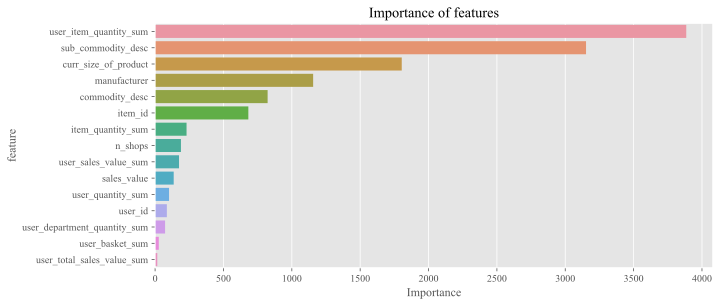

In [32]:
important_features_top = show_feature_importances(X_train_feat.columns,
                                                  lgb.feature_importances_, get_top=16)

In [33]:
df_results.to_csv('result_2lvl_model.csv', index=False)